In [1]:
import sys
sys.path.append("..")

from matplotlib import pyplot as plt

import torch
import numpy as np
from torch.distributions import Beta

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sgnuts import NUTS

In [2]:
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

    
def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

In [3]:
sgnuts_kernel = NUTS(model, 
                subsample_positions=[0, 1],
                batch_size=5,
                potential_fn=None,
                learning_rate=0.01, 
                momentum_decay=0.1,
                resample_every_n=50, 
                obs_info_noise=False, 
                compute_obs_info='every_sample',
                use_multinomial_sampling=True,
                max_tree_depth=10,
                )

sgnuts_mcmc = MCMC(sgnuts_kernel, num_samples=1000)

sgnuts_mcmc.run(x1, x2)
sgnuts_samples = sgnuts_mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [00:34, 57.81it/s, step size=1.00e-01]


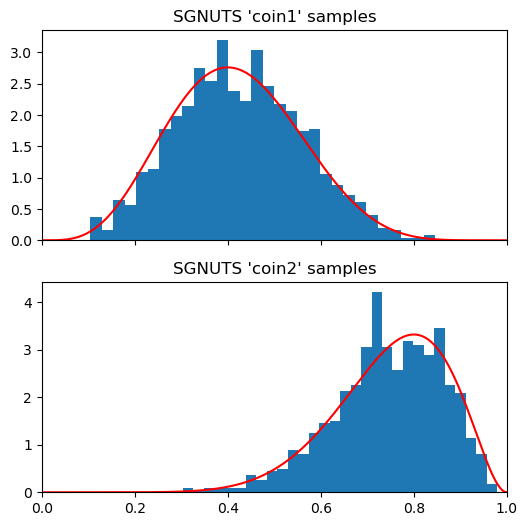

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

def analytic_posterior(x, alpha, beta):
    fn = Beta(alpha, beta)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

with torch.no_grad():
    axs[0].hist(sgnuts_samples["coin1"].numpy(), density=True, bins=30)
    axs[0].set(title="SGNUTS 'coin1' samples")
    axs[0].plot(x, analytic_posterior(x, 5., 7.), "r", label="analytic posterior")
    axs[1].hist(sgnuts_samples["coin2"].numpy(), density=True, bins=30)
    axs[1].set(title="SGNUTS 'coin2' samples")
    axs[1].plot(x, analytic_posterior(x, 9., 3.), "r", label="analytic posterior")
plt.xlim((0.0, 1.0))
plt.show()